# Data Analysis
This module will introduce and examine the project lifecycle stage, 'data analysis' (or, exploratory data analysis). 
However, rather than focusing solely on the statistical or technical techniques employed in modern data analysis, we will approach this stage with a contextual, bias-aware perspective. 
That said, we will make use of [Jupyter notebooks](https://jupyter.org)—a popular tool in data science—to aid our exploratory data analysis by visualising some data.

```{admonition} Note
You do not need to be familiar with either Python or Jupyter Notebooks if you just want to gain an understanding of how social, cognitive, and statistical biases interact and affect downstream stages in the research and innovation lifecycle. 
But the code is presented for those who wish to get more "hands-on".

You can also explore this code in an interactive Jupyter notebook: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/chrisdburr/turing-commons/master?urlpath=https%3A%2F%2Fgithub.com%2Fchrisdburr%2Fturing-commons%2Fblob%2Fmaster%2Fguidebooks%2Frri%2Fchapter4%2Fproject_design%2Fdata_analysis.ipynb)
```


## What is Exploratory Data Analysis?

Exploratory data analysis (EDA) is a crucial stage in the project lifecycle. It is where a number of techniques are employed for the purpose of gaining a better understanding of the dataset and any relationships that exist between the relevant variables. Among other things, this could mean,

- Describing the dataset and important variables
- Cleaning the dataset
- Identifying missing data and outliers, and deciding how to handle them
- Provisional analysis of any relationships between variables
- Uncovering possible limitations of the dataset (e.g. class imbalances) that could affect the project

We will cover each of these sub-stages of EDA briefly, but to reiterate, our primary focus in this section is on the risks and challenges that stem from a variety of biases that can cause cascading issues that affect downstream tasks (e.g. model training).

## COVID-19 Hospital Data

For the purpose of this section we have created a synthetic dataset that contains 27308 records for fictional patients who were triaged (and possibly admitted) to a single hospital for treatment of COVID-19. 

The dataset has been designed with this pedagogical task in mind. 
Therefore, although we relied upon plausible assumptions when developing our generative model, the data are not intended to be fully representative of actual patients. Our methodology for generating this dataset can be [found here](synthetic_data_generation.ipynb).

### Importing Data

First of all, we need to import our data and the software packages that we will use to describe, analyse, and visualise the data. 
The following lines of code achieve this by importing a series of software packages and then loading a csv file `covid_patients_syn_data.csv` into a DataFrame `df` using the `pd.read_csv` command from the Pandas package.

In [10]:
# The following lines import necessary packages and renames them 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

# This line imports data from a csv file 

df = pd.read_csv('covid_patients_syn_data.csv')

### Describing the Data

Once we have imported our data, we will then want to identify what variables there are, what their typical values are, and also assess a variety of other summary statistics. 
We can use several commands to help us describe our dataset and get a quick overview.

First, we can use the `shape` attribute to list the number of rows and columns in our dataset.
The output (27308, 12) means that there are 27308 rows and 12 columns.


In [11]:
df.shape

(27308, 12)

Second, we can use the `head` attribute to return the first 5 rows of our dataset, which can be useful if you want to see a small sample of values for each variable.

In [12]:
df.head() 

,Unnamed: 0,nhs_id,site_id,age,sex,ethnicity,height,weight,admitted,admission_date,intrusive_ventilation,died
0,1,b2d7345e,UHJ_43643,48,F,White,1.577876,33.388356,False,NaN,False,False
1,2,ead19985,UHJ_43643,80,F,White,1.640164,71.938813,False,NaN,False,False
2,3,669082d5,UHJ_43643,66,F,White,1.469061,31.679456,False,NaN,False,False
3,4,150f52d1,UHJ_43643,85,M,White,1.846977,77.164762,False,NaN,False,True
4,5,5feb9000,UHJ_43643,53,NaN,White,1.736242,73.458529,False,NaN,False,False


This can be helpful, but also misleading. 
For instance, based on the `ethnicity` label you may get the false impression that the dataset comprises only individuals who fall into the `White` category.
However, this is not the case.
The following command lists the different values for the `ethnicity` column and also shows that `White` makes up ~82% of the rows, which helps explain why the first 5 are all `White`.

In [13]:
ethnicity = df.ethnicity.value_counts(normalize=True)
print(ethnicity)

White                             0.820309
Asian / Asian British             0.088143
Black / Black British             0.053318
Other ethnic groups               0.027977
Mixed / Multiple ethnic groups    0.010253
Name: ethnicity, dtype: float64


A similar process can be done for the dataset itself using the `columns` attribute.
This is helpful if you want to quickly see which variables you will have access to during your analysis.

In [14]:
df.columns

Index(['Unnamed: 0', 'nhs_id', 'site_id', 'age', 'sex', 'ethnicity', 'height',
       'weight', 'admitted', 'admission_date', 'intrusive_ventilation',
       'died'],
      dtype='object')

Then, for each of the columns we can also see how many *unique* values there are for each of the variables by using the `nunique` attribute (i.e., number (n) of unique values).
For example, we can verify that there are 5 different values for `ethnicity` as already seen.
These values align with the formal list used by Public Health England in a report on the [Disparities in the risk and outcomes of COVID-19](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/908434/Disparities_in_the_risk_and_outcomes_of_COVID_August_2020_update.pdf)—this report was used as the basis for generating our synthetic data.

In [15]:
df.nunique(axis=0)

Unnamed: 0               27308
nhs_id                   27307
site_id                      1
age                         70
sex                          2
ethnicity                    5
height                   27308
weight                   27308
admitted                     2
admission_date              67
intrusive_ventilation        2
died                         2
dtype: int64

These commands can be helpful for describing some basic aspects of our dataset. But what about more useful statistical information?
For that we have the `describe` attribute, which returns the numeric values for `count`, `mean`, `standard deviation`, `min`, and `max`.
The code after the brackets (`apply(lambda s: s.apply(lambda x: format(x, 'f'))` helps improve readability.)

In [16]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,Unnamed: 0,age,height,weight
count,27308.000000,27308.000000,27308.000000,27308.000000
mean,15013.859675,59.152995,1.699453,71.601769
std,8663.023499,20.311303,0.102201,17.835281
min,1.000000,20.000000,1.402760,-8.046726
25%,7502.750000,43.000000,1.623002,59.454984
50%,15046.500000,59.000000,1.690112,71.334741
75%,22500.250000,78.000000,1.773432,83.484033
max,29999.000000,89.000000,5.900000,155.031500


### Cleaning the Data

#### Removing Unnecessary Variables

Our dataset has been created for this specific task, so there isn't much cleaning that is required.
Datasets that are downloaded from public repositories or sources, however, may not be so well structured and will likely require tidying up. 
For instance, there may be redundant columns that are not needed, such as the `site_id` column for our dataset, which is the same for all values due to the data being collected from a single hospital site (`UHJ_43643`).
These can be easily removed with the `drop` function.

In [17]:
df_cleaned = df.drop(['site_id'], axis=1)
df_cleaned.head()

,Unnamed: 0,nhs_id,age,sex,ethnicity,height,weight,admitted,admission_date,intrusive_ventilation,died
0,1,b2d7345e,48,F,White,1.577876,33.388356,False,NaN,False,False
1,2,ead19985,80,F,White,1.640164,71.938813,False,NaN,False,False
2,3,669082d5,66,F,White,1.469061,31.679456,False,NaN,False,False
3,4,150f52d1,85,M,White,1.846977,77.164762,False,NaN,False,True
4,5,5feb9000,53,NaN,White,1.736242,73.458529,False,NaN,False,False


#### Removing Outliers

It is also possible that there may be some outliers that are probably the result of human mistakes in recording.  For example, someone may enter a height in feet and inches, such that we end up with a value of greater than 5 in that column.
It's probably a safe assumption to assume that this is a mistake!

array([[<AxesSubplot:title={'center':'height'}>]], dtype=object)

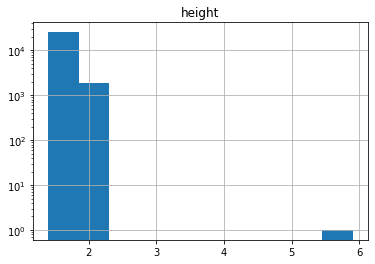

In [18]:
df_cleaned.hist("height", log=True) 

We can see there is one entry with a height of between 5.5 and 6m!  We can manually remove this row, and any others with a height greater than 2.5m:

array([[<AxesSubplot:title={'center':'height'}>]], dtype=object)

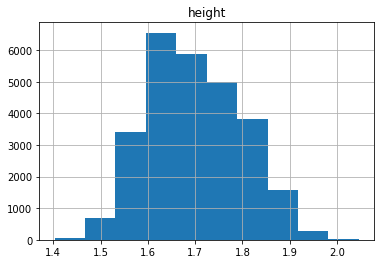

In [19]:
df_cleaned = df_cleaned[df_cleaned.height< 2.5]
df_cleaned.hist("height")

#### Handling Missing Data

One of the biggest challenges with cleaning datasets is choosing how to handle missing data. 
As you can see from the following line of code, there are 1326 rows with missing data in the "sex" column, which are represented in our datasets using the `null` value.

In [21]:
len(df_cleaned[df_cleaned.sex.isnull()])

1326

Missing data is a problem for data analysis and model training, because the lack of a value can cause errors for functions or calculations.
The simplest thing that one can do is to remove any rows that have missing data.
This solves a technical problem that can arise downstream, but can also introduce bias.   

The best case scenario is that the missingness occurs at random—in this case removing the rows would reduce our statistical precision (because we would have a smaller dataset), but would not bias the result.

However, if the reason why the data is missing is correlated with some other variable, then simply removing the affected rows will cause the dataset to become skewed in some way. 

The best thing to do in this case could be to _impute_ the missing values, based on other variables in the same row. 
For example, we could look at the other columns and try to infer whether the row with missing data is most similar to the average `male` or `female` in the dataset.[^imputation]
However, this is often a complex process, and needs to be done with care!

[^imputation]: This is only one type of imputation method. See {cite}`roy2021` for an overview of other methods as well as a general introduction to types of missing data.

To begin, we need to consider why there are so many `null` values for the `sex` variable?

As noted, the best case scenario is that they are missing completely at random, and are simply a result of human error. 
Here, there is no correlation between the elements that have the missing data and the outcome being studied (i.e. `death`).
However, another possibility is that the individuals who were recorded as `null` did not feel that the data recording method provided sufficient means to present themselves as a *non-binary* person.
As such, they could have refused to have their sex recorded unless there was also an option to record `gender`. 
If this were the case, then either removing all the rows or trying to replace the missing data with `male` or `female` would represent a serious breach of trust between the researchers and the data subjects, and could also constitute a representational harm for those affected.

As you can see, data analysis is a complex and challenging process, and we haven't even really started analysing the data yet!



### Analysing the Data

<!-- This section needs to add some useful illustrations of how Python can help you identify and understand correlations between variables in your dataset, and help document your exploratory data analysis method by using Jupyter Notebooks. -->

For convenience, we may want to calculate some new variables based on those already in the dataset, that we think may be relevant.  For example, there have been reports that Body Mass Index (BMI) is a risk factor for Covid.  We can calculate this easily given the height and weight:

In [ ]:
df_cleaned["BMI"] = df_cleaned["weight"]/pow(df_cleaned["height"],2)
df_cleaned.head(20)

A quick way to get an idea of what variables are correlated with one another is to plot a "heatmap".  Higher numbers in this plot represent stronger correlations (note the diagonal line of red squares all containing "1" - every variable is 100% correlated with itself!)

In [ ]:
# The following lines return a correlation matrix, for the cleaned dataframe, using the seaborn package
corr = df_cleaned[["age","BMI","admitted","intrusive_ventilation","died"]].corr()# plot the heatmap

ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Note that this heatmap only works for numeric (or boolean) variables.  For categorical variables such as "ethnicity", we will use other methods to visualise the data.

### Visualising the Data

<!-- This section should show how including people who died in care homes would affect the correlation between age and one or more of the outcomes. This will be used to help support the missing data narrative. -->

As we saw from the heatmap above, the age of the patient is perhaps the most important variable with regard to outcomes such as hospital admission or death.  We will therefore separate the data into different "bins" of age, to see if we can observe other dependencies.

This is a bit tricky to do in pandas, we need to define the bin boundaries, and then "group by" the other variable that we're interested in, summing the numbers of patients and deaths over each category.

In [ ]:
df_plot = df_cleaned.copy(deep=True)
# add a 'counter' variable, which is just 1 for each row, so that when we sum over categories, we know how many rows we 
# originally had in that category
df_plot["counter"] = 1.0
# now we want to put the data in bins of age-range and ethnicity, and sum the numbers of
# patients (total, admitted, ventilated, died) over these bins
bins = np.arange(20,100,10)
df_plot = df_plot.groupby(["ethnicity",pd.cut(df_plot["age"], bins)]).sum()
# calculate probability that patient died by dividing num(died) by the total in each bin
df_plot["prob_died"] = df_plot["died"]/df_plot["counter"] 
# we can also calculate the uncertainty on this probability, using binomial errors
df_plot["prob_died_std"] = np.sqrt(df_plot["prob_died"]*(1-df_plot["prob_died"])/df_plot["counter"])
# at this point, we have a redundant column "age" which is the sum of all the ages in the bin - drop this,
# so that we can then promote the index age-range to a column (which will also be called "age")
df_plot = df_plot.drop(["age"], axis=1)
# we can also drop the other columns that no longer make sense since we have summed over
# all the patients in the age range
df_plot = df_plot.drop(["Unnamed: 0","height","weight", "BMI"], axis=1)
df_plot = df_plot.reset_index()
# convert this new "age" column to a string
df_plot["age"] = df_plot["age"].astype(str)
df_plot[["ethnicity","age","admitted","intrusive_ventilation","prob_died"]]


In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
sns.pointplot(data=df_plot, x="age", y="prob_died", hue="ethnicity")

Ideally we would plot error bars here so we could see the uncertainties on the probabilities, but it does seem to be a consistent pattern that "White" patients had a lower probability of death across a range of ages, while for older patients, the "Asian / Asian British" ethnicity had a higher probability of dying.

### Dependency on other factors

It is generally very difficult to quantify correlations in situations like this where multiple factors might affect the probability of a death, especially when these factors might be correlated with one another.   
We can try though to see whether we can see a dependency on sex, and/or BMI.  Since we know that the strongest dependency is on age, we will just choose a limited age range to make this plot - in order to have a reasonable number of patients we'll look at the rows with age between 70 and 80.

In [ ]:
df_newplot = df_cleaned.copy(deep=True)
df_newplot = df_newplot[(df_newplot.age > 70) & (df_newplot.age < 80)]
df_newplot["counter"] = 1.0
# now we want to put the data in bins of BMI and sex, and sum the numbers of
# patients (total, admitted, ventilated, died) over these bins
bins = np.arange(10,45,6)
df_newplot = df_newplot.groupby(["sex",pd.cut(df_newplot["BMI"], bins)]).sum()
# calculate probability that patient died by dividing num(died) by the total in each bin
df_newplot["prob_died"] = df_newplot["died"]/df_newplot["counter"] 
df_newplot["prob_died_std"] = np.sqrt(df_newplot["prob_died"]*(1-df_newplot["prob_died"])/df_newplot["counter"])
df_newplot = df_newplot.drop(["BMI","Unnamed: 0","age","height","weight"], axis=1)
df_newplot = df_newplot.reset_index()
# convert this new "BMI" column to a string
df_newplot["BMI"] = df_newplot["BMI"].astype(str)
df_newplot.head(8)

In [ ]:
sns.pointplot(data=df_newplot, x="BMI", y="prob_died", hue="sex")

Well, we can clearly see that there is a difference between men and women, with men having a higher probability of death right across the BMI range.

But the dependence on BMI doesn't look like we might expect - why is this?   Well, it would take a detailed analysis to find out for sure, but one plausible hypothesis is that BMI is negatively correlated with age.  (In fact if we look at the [code used to generate this synthetic dataset](Synthetic_data_generation.ipynb) we can see that this is indeed the case - average BMI peaks at age 60 and decreases linearly with age after that).  Even though we only took a limited age-range, the variation within this 10-year slice is still big enough that it is the dominant factor in determining the shape of this plot.

This is just one example of the pitfalls of trying to ascertain relationships between outcomes and variables - it's not easy! 

## Selection Bias andfig, axes = plt.subplots(1,2, figsize=(15,5))
# The following lines return a correlation matrix, for the cleaned dataframe, using the seaborn package
corr = df_cleaned[["age","BMI","admitted","intrusive_ventilation","died"]].corr()# plot the heatmap

axes[0] = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=axes[0], annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
bottom, top = axes[0].get_ylim()
axes[0].set_ylim(bottom + 0.5, top - 0.5)
# add BMI to the new dataset
df_all["BMI"] = df_all["weight"]/pow(df_all["height"],2)

corr_all = df_all[["age","BMI","admitted","intrusive_ventilation","died"]].corr()# plot the heatmap
axes[1] = sns.heatmap(corr_all, xticklabels=corr_all.columns, yticklabels=corr_all.columns, ax=axes[1], annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
bottom, top = axes[1].get_ylim()
axes[1].set_ylim(bottom + 0.5, top - 0.5) Missing Data

As well as isolated rows with missing or incorrectly entered data, it is possible that there are entire categories that are under-represented in our dataset, as an artifact of the data collection procedure.   For example, perhaps we are missing some of the older patients in our dataset, as they may have been too frail to even present at the hospital.
We are in the fortunate situation here of using synthetic data, so we can see the effect of this by adding back in some rows that were artificially removed in the dataset we have used up to now:

In [ ]:
df_all = pd.read_csv("covid_patients_syn_data_unbiased.csv")
df_all.shape

To see how the data was affected, we can compare the histograms of ages of patients, and patients that died, between our dataset and the dataset with the missing rows restored.

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,6))
ages_orig = list(df_cleaned["age"])
ages_all = list(df_all["age"])
ages_died_orig = list(df_cleaned[df_cleaned["died"]==True]["age"])
ages_died_all = list(df_all[df_all["died"]==True]["age"])

axes[0].hist(ages_all,bins=10,range=(0,100), alpha=0.5, label="missing dataset")
axes[0].hist(ages_orig,bins=10,range=(0,100), alpha=0.5, label="our dataset")
axes[0].set_xlabel("Age of patient")
axes[0].set_ylabel("Number of cases")
leg = axes[0].legend()

axes[1].hist(ages_died_all,bins=10,range=(0,100), alpha=0.5, label="missing dataset")
axes[1].hist(ages_died_orig,bins=10,range=(0,100), alpha=0.5, label="our dataset")
axes[1].set_xlabel("Age of patient")
axes[1].set_ylabel("Number of deaths")
leg = axes[1].legend()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# The following lines return a correlation matrix, for the cleaned dataframe, using the seaborn package
corr = df_cleaned[["age","BMI","admitted","intrusive_ventilation","died"]].corr()# plot the heatmap

axes[0] = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=axes[0], annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
bottom, top = axes[0].get_ylim()
axes[0].set_ylim(bottom + 0.5, top - 0.5)
# add BMI to the new dataset
df_all["BMI"] = df_all["weight"]/pow(df_all["height"],2)

corr_all = df_all[["age","BMI","admitted","intrusive_ventilation","died"]].corr()# plot the heatmap
axes[1] = sns.heatmap(corr_all, xticklabels=corr_all.columns, yticklabels=corr_all.columns, ax=axes[1], annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
bottom, top = axes[1].get_ylim()
axes[1].set_ylim(bottom + 0.5, top - 0.5)

```{admonition} Author
The content of this notebook was co-authored with Nick Barlow.
```